<a href="https://colab.research.google.com/github/RoyRin/multi-party-learning/blob/master/PATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.version

'3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]'

In [4]:
!cat /content/drive/MyDrive/academics/columbia/neural_networks/project/requirements.txt | grep "syft"



syft-proto==0.5.3 \
syft==0.2.9 \


In [5]:
#%%capture
#! python3 -m pip install -r /content/drive/MyDrive/academics/columbia/neural_networks/project/requirements.txt

#!pip install --upgrade IPython 
!pip install torchviz
# https://opacus.ai/tutorials/building_text_classifierz
#!pip install pycodestyle pycodestyle_magic flake8
!pip install torch torchvision
!pip install tensorboard
!pip install --upgrade syft torch numpy

#!pip ins

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=416e2803f9a8022db79cbd7af43357602c7b7f29dddb787c52f8bd9d0054db79
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz
     |████████████████████████████████| 606 kB 11.1 MB/s 
     |████████████████████████████████| 15.7 MB 36.4 MB/s 
     |████████████████████████████████| 961 kB 45.1 MB/s 
     |████████████████████████████████| 789 kB 43.6 MB/s 
     |████████████████████████████████| 6.2 MB 43.1 MB/s 
     |████████████████████████████████| 11.3 MB 44.8 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 40 kB 5.4 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 10.1 MB 51.3 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 288 kB 55.2 MB/s 
     |███████████████

In [6]:

%load_ext tensorboard

%matplotlib inline

In [7]:
# from pytorch tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import os
import tarfile
import numpy as np
import toolz 
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple, OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
#import torchvision.transforms as transforms
import torchvision.transforms as tt
import torchvision.models as models

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

# privacy
# https://opacus.ai/tutorials/building_text_classifier
#from opacus import PrivacyEngine
#from opacus.dp_model_inspector import DPModelInspector
#from opacus.utils import module_modification

In [8]:
torch.manual_seed(0)
np.random.seed(0)
#torch.use_deterministic_algorithms(False)

## load data

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

# beep boop baap - if it breaks -it's because I am reusing the datasets
trainset = datasets.MNIST(
    "~/.pytorch/MNIST_data/", train=True, download=True, transform=transform)
testset = datasets.MNIST(
      "~/.pytorch/MNIST_data/", train=False, download=True, transform=transform)


batch_size = 64
load = lambda dataset : torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

trainloader, testloader = load(trainset), load(testset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [10]:
def split_dataset_federated(count):
  people = [sy.VirtualWorker(hook, id=f"worker_{i}") for i in range(count)]

  federated_train_loader = sy.FederatedDataLoader(
      train_set.federate(people), batch_size=64, shuffle=False) # split the data across Jake and John

  test_loader = torch.utils.data.DataLoader(
      test_set, batch_size=64, shuffle=False)
  
  return people, federated_train_loader, test_loader



## train model helper functions

In [11]:
# transfer to GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
# Transfering data to the device in use (In our case GPU)
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

In [12]:
def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def epoch_end(epoch, result):
      print(f"Epoch [{epoch}], train_loss: {result['train_loss']},",
            f"val_loss: {result['val_loss']}, val_acc: {result['val_acc']}")

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
def validation_step(model, batch, criterion):
    images, labels = batch 
    out = model(images)                    # Generate predictions
    loss = criterion(out, labels)   # Calculate loss
    acc = compute_accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

def training_step(model, batch, criterion):
    images, labels = batch 
    out = model(images) # Generate predictions
    return criterion(out, labels) # Calculate loss

    

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

def accuracy(preds, labels):
    return (preds == labels).mean()

@torch.no_grad()
def evaluate(model, validation_loader, criterion):
    model.eval()
    outputs = [validation_step(model, batch, criterion) for batch in validation_loader]
    return validation_epoch_end(outputs)



# https://opacus.ai/tutorials/building_text_classifier
batch_size = BATCH_SIZE = 32
VIRTUAL_BATCH_SIZE = 512
assert VIRTUAL_BATCH_SIZE % BATCH_SIZE == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / BATCH_SIZE)

# to do: put these in a nice place
MAX_GRAD_NORM = 0.1
SAMPLE_RATE = BATCH_SIZE / len(trainset)

def train_single_epoch(*, model, train_loader, train_losses,
                       lrs, optimizer, sched, grad_clip, 
                       accuracies = None,
                       criterion = None):
    model.train()
    if not criterion:
      criterion = nn.CrossEntropyLoss()
    total_correct = 0

    epoch_train_losses, epoch_lrs, epoch_accuracies = [], [], []
    for batch_id, (images, target) in enumerate(train_loader):
        images = images.to(device)
        target = target.to(device)

        output= model(images)
        loss = criterion(output, target)

        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = target.detach().cpu().numpy()        


        # get stats
        total_correct+= get_num_correct(output, target) 
        acc = accuracy(preds, labels) 
        epoch_accuracies.append(acc)
        epoch_train_losses.append(loss.item())
        epoch_lrs.append(optimizer.param_groups[0]['lr'])

        loss.backward()
        
        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), MAX_GRAD_NORM)    

        optimizer.step()
        optimizer.zero_grad() # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        # update learning rate
        sched.step
    
    train_losses.append(epoch_train_losses)
    lrs.append(epoch_lrs)
    accuracies.append(epoch_accuracies)
    return total_correct


def log_epoch(model, epoch, total_correct, 
              train_loader, val_loader, 
              lrs, train_losses, N, 
              writer, criterion, accuracies):
        train_loss = np.mean(train_losses[-1])
        train_accuracy = np.mean(accuracies[-1])
        # add the loss from the entire previous batch
        #total_loss = sum([t.item() for t in train_losses[-len(train_loader):]])

        writer.add_scalar("train_Loss", train_loss, epoch)
        writer.add_scalar("train_Correct", total_correct, epoch)
        #writer.add_scalar("Train_Accuracy", total_correct/ N, epoch)
        writer.add_scalar("Train_Accuracy", train_accuracy, epoch)
         

        for name, param in model.named_parameters():
          writer.add_histogram(name, param, epoch)  
        
        # Validation phase
        result = evaluate(model, val_loader, criterion) ## this is where the difference between the accuracy definitions lies.
        writer.add_scalar("val_Loss", result["val_loss"], epoch)
        writer.add_scalar("val_Accuracy", result["val_acc"], epoch)
        # logging information
        result['train_loss'] = train_loss
        result['lrs'] = lrs if lrs else []
        return result 

# Lookie here # https://jovian.ai/roubish/final-course-assignment
def train_model(*, model, epochs, 
                max_lr, train_loader, 
                val_loader, weight_decay=0, 
                grad_clip=None, optimizer=None, 
                writer = None, criterion = None):
  
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    if not optimizer:
      optimizer = torch.optim.SGD(model.parameters(), 
                                  max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    if not criterion:
      criterion = nn.CrossEntropyLoss()
    first_start = datetime.datetime.now()
    
    train_losses, lrs, accuracies = [], [], []

    for epoch in range(epochs):
        start = datetime.datetime.now()
        print(f"Training epoch: {epoch}/{epochs}")
        # Training Phase 
        model.train()

        
        # train the epoch
        total_correct = train_single_epoch(model = model, train_loader= train_loader, 
                                           train_losses= train_losses,
                                           lrs = lrs, optimizer= optimizer, 
                                           sched = sched, grad_clip = grad_clip                                           ,
                                           criterion = criterion, accuracies= accuracies)  

        result = log_epoch(model, epoch, total_correct, 
                           train_loader, val_loader, lrs, train_losses, 
                           N = len(trainset), writer = writer, 
                           criterion= criterion, accuracies= accuracies)
        # we don't need this for now
        epoch_end(epoch, result)
        history.append(result)
        print(f"time for epoch {epoch} : {(datetime.datetime.now() - start)}")
    
    print(f"total time: {(datetime.datetime.now() - first_start)}")
    return history


def select_n_random(data, labels, n=100):
    ''' Selects n random datapoints and their corresponding labels from a dataset '''
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    rand_labels = [trainset.targets[i] for i in perm][:n]
    return data[perm][:n], rand_labels

def log_model_to_tensorboard(model, dataset, writer = None, n = 32):
  """ log model information to tensorboard (things like model graph and features) """
  # log to tensorboard writer
  #class_labels
  # select random images and their target indices
  if not writer:
    return
  images, labels = select_n_random(dataset.data, dataset.targets, n = n)
  writer.add_graph(model, images)



In [13]:
def save_model(model, path):
    """ helper function to save model"""
    #torch.save(model.state_dict(), 'cifar100-resnet12layers.pth')
    torch.save(model.state_dict(), path)

def load_model(path, base_model, map_location = None):
    """ helper function to load model"""
    model = base_model
    loaded_dict = torch.load(path, map_location = map_location)
    for name, buffer in model.named_buffers():
      if name not in loaded_dict:
        loaded_dict[name] = buffer

    model.load_state_dict(loaded_dict)  
    model = to_device(model, device) 
    return model


In [14]:
ASSETS_PATH = "/content/drive/MyDrive/academics/columbia/neural_networks/project/data"
ASSETS_BASE_PATH = os.path.join(ASSETS_PATH, "round_6")

In [15]:

def get_new_optimizer(model ):
  optimizer_type = torch.optim.Adam
  optimizer_type = torch.optim.RMSprop
  return optimizer_type(model.parameters(), max_lr, weight_decay=weight_decay)
  
def train_and_log(*, model, 
                  epochs, 
                  trainloader, testloader, 
                  tensorboard_name = ASSETS_BASE_PATH+ "tb.pth",
                  max_lr= 1.e-3, 
                  grad_clip = 0.3, #MAX_GRAD_NORM, 
                  weight_decay=1.e-4, #weight_decay, 
                  optimizer = None, criterion = None):
  if not optimizer:
    optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
  if not criterion:
    criterion = nn.CrossEntropyLoss()

  with SummaryWriter(tensorboard_name) as writer_:
      #result = evaluate(model, testloader) # need to train first
      history = train_model(model = model, epochs = EPOCHS,max_lr= max_lr, 
                          train_loader =trainloader, val_loader = testloader, 
                          weight_decay=weight_decay,
                          grad_clip=MAX_GRAD_NORM,
                          optimizer=optimizer, writer = writer_, 
                          criterion = criterion)
      history.append(evaluate(model = model, validation_loader = testloader, criterion= criterion))
      return history


def do_it_all( *, model, model_name, save_path, tensorboard_path, trainloader_, val_loader_,
              num_classes = 100, 
              device= device, epochs= 30):

    ret = {
        "save_path" : save_path,
        "history": None,
        "model_name": model_name
    }

    optimizer_type = torch.optim.Adam
  
    if os.path.exists(save_path):
        print(f"path {save_path} already saved to. SKIPPING.")
        return ret
    optimizer = get_new_optimizer(model)
    
    history = train_and_log(model = model,
                            epochs = epochs, 
                            trainloader=trainloader_, 
                            testloader=val_loader_, 
                            tensorboard_name = tensorboard_path,
                            max_lr= max_lr, 
                            grad_clip = MAX_GRAD_NORM, 
                            weight_decay=weight_decay, 
                            optimizer = optimizer)

    save_model(model, save_path)

    ret["history"] = history 
    return ret


## model params


In [16]:
### defaults behaviors:

MAX_GRAD_NORM = 0.3
batch_size = BATCH_SIZE = 32
SAMPLE_RATE = BATCH_SIZE / len(trainset)

VIRTUAL_BATCH_SIZE = 64
assert VIRTUAL_BATCH_SIZE % BATCH_SIZE == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / BATCH_SIZE)

max_lr = 1e-3 #0.01
weight_decay =1e-4

DELTA = 1. * 1e-5
EPSILON = 2.

optimizer_type = torch.optim.Adam
criterion = nn.CrossEntropyLoss()
EPOCHS = 20


In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


## PATE


In [18]:
# 1 - split the dataset into uneven chunks
# 2 - train the models, save them, and store where you are saving them (persist the data somewhere like to a yaml, or you will lose it)
# 3 - have each model vote on each data point in the test-dataset, store that to a yaml
# 4 - 

In [19]:
import logging

In [20]:
import yaml
from pathlib import Path

In [21]:
def open_yaml(filename):
  """ return the contents of yaml as a dictionary """
  path = Path(filename)
  if not path.is_file():
      return None
  try:
      with open(path, "r") as infile:
          return yaml.safe_load(infile)
  except Exception as e:
      logging.info(e)
  return {}

def write_yaml(filename, d):
    """ dump contents of d into filename, in yaml format"""
    with open(filename, 'w') as file:
        yaml.dump(d, file, default_flow_style=False)


In [22]:
def get_data_loaders(data_loader, num_teachers):
    """ Function to create data loaders for the Teacher classifier """
    # data per teacher
    data_per_teacher = len(data_loader) // num_teachers

    return [torch.utils.data.DataLoader(
                            Subset(data_loader, 
                                   np.arange(0,data_per_teacher)+(data_per_teacher * teacher)), 
                            batch_size=batch_size) 
                      for teacher in range(num_teachers)]
    """
    teacher_loaders = []
    for i in range(data_size):
        indices = list(range(i*data_size, (i+1)*data_size))
        subset_data = Subset(data_loader, indices)
        loader = torch.utils.data.DataLoader(subset_data, batch_size=batch_size)
        teacher_loaders.append(loader)
    return teacher_loaders
    """

N = len(trainset)
percent = int(N/100)
lengths = [percent*30, percent * 20, percent * 15, percent * 10, percent * 5,percent * 5, percent * 5, percent * 5,percent * 5]

def get_uneven_data_loaders(dataset, lengths):
    return torch.utils.data.random_split(dataset, lengths)
    



In [23]:
len(trainset)
import datetime

In [24]:
# Note, 
# experimnet 1:
"""
EPOCHS = 25
num_teachers = 600 #10 
"""
EPOCHS = 25
num_teachers = 100 

batch_size = 50 
prefix  = ""# "test_1"

teacher_loaders = get_data_loaders(trainset, num_teachers)

experiments_base_save = os.path.join(f"{ASSETS_BASE_PATH}", prefix)

meta_yaml = os.path.join(experiments_base_save, "meta.yaml") 

meta = open_yaml(meta_yaml)
if not meta:
  meta = {}
  
num_classes = len(trainset.class_to_idx)

for ind, teacher_loader in enumerate(teacher_loaders): 
    start = datetime.datetime.now()
    model_name = f"model_{ind}_of_{num_teachers}"
    print(model_name)
    model = to_device(Model(), device)
    
    experiments_base_save = os.path.join(f"{experiments_base_save}", model_name)
    # make the directory to which we will save stuff
    os.makedirs(os.path.dirname(experiments_base_save), exist_ok =True) 
    tensorboard_path = experiments_base_save 
    save_path = experiments_base_save + ".pth"
    print(f"tensorboard path is {tensorboard_path}")
    print(f"save_path is {save_path}")
    
    # 
    d = do_it_all(model = model, model_name = model_name,
                                     save_path = save_path, tensorboard_path= tensorboard_path, 
                                     trainloader_ = teacher_loader, val_loader_ = testloader,
                                     num_classes = num_classes, device = device, epochs = EPOCHS)
    print(ind)
    print(d)
    meta[model_name] =d 
    print(f"Model training took {datetime.datetime.now() - start}")

write_yaml(meta_yaml, meta)

model_0_of_100
tensorboard path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/model_0_of_100
save_path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/model_0_of_100.pth
path /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/model_0_of_100.pth already saved to. SKIPPING.
0
{'save_path': '/content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/model_0_of_100.pth', 'history': None, 'model_name': 'model_0_of_100'}
Model training took 0:00:09.613046
model_1_of_100
tensorboard path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/model_0_of_100/model_1_of_100
save_path is /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/model_0_of_100/model_1_of_100.pth
path /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/model_0_of_100/model_1_of_100.pth already saved to. SKIPPING.
1
{'save_pat

In [25]:
meta.keys()

dict_keys(['model_0_of_100', 'model_10_of_100', 'model_11_of_100', 'model_12_of_100', 'model_13_of_100', 'model_14_of_100', 'model_15_of_100', 'model_16_of_100', 'model_17_of_100', 'model_18_of_100', 'model_19_of_100', 'model_1_of_100', 'model_20_of_100', 'model_21_of_100', 'model_22_of_100', 'model_23_of_100', 'model_24_of_100', 'model_25_of_100', 'model_26_of_100', 'model_27_of_100', 'model_28_of_100', 'model_29_of_100', 'model_2_of_100', 'model_30_of_100', 'model_31_of_100', 'model_32_of_100', 'model_33_of_100', 'model_34_of_100', 'model_35_of_100', 'model_36_of_100', 'model_37_of_100', 'model_38_of_100', 'model_39_of_100', 'model_3_of_100', 'model_40_of_100', 'model_41_of_100', 'model_42_of_100', 'model_43_of_100', 'model_44_of_100', 'model_45_of_100', 'model_46_of_100', 'model_47_of_100', 'model_48_of_100', 'model_49_of_100', 'model_4_of_100', 'model_50_of_100', 'model_51_of_100', 'model_52_of_100', 'model_53_of_100', 'model_54_of_100', 'model_55_of_100', 'model_56_of_100', 'model

In [26]:
def prediction_by_img(model, img, verbose= False):
  # beep boop baap - this is where the erorr is 
  """
  returns confidence, prediction
  """
  img = img.cuda()
  img.unsqueeze_(0)
  with torch.no_grad():
    yb = model(img)
  softmax = torch.nn.functional.softmax(yb[0], dim=0)
  conf, pred = torch.max(softmax, dim=0)
  #_, pred = torch.max(yb, dim=1)
  if verbose:
    plt.imshow(img.permute(1, 2, 0))
    print(f"prediction: {trainset.classes[pred]}, confidence {conf * 100}%")
  return conf, pred

def prediction_by_imgs(model, img, verbose= False):
  """
  returns confidence, prediction
  """
  img = img.cuda()
  img.unsqueeze_(0)
  with torch.no_grad():
    yb = model(img)
  softmax = torch.nn.functional.softmax(yb, dim=1)
  conf, pred = torch.max(softmax, dim=1)
  #_, pred = torch.max(yb, dim=1)
  return conf, pred

In [27]:
list(meta.keys())[-1]


'model_9_of_100'

In [28]:
# manual inspection of where a model disagrees
if True:
  model = load_model( meta["model_49_of_100"]['save_path'], Model())
  c = 0
  for ind, (data,target) in enumerate(trainset):
      conf, pred = prediction_by_img(model, data)
      if pred != target:
        c+=1
        print(f"{c}: @ {ind} : prediction {pred}, target {target}")
      if ind ==1000:
        print(f"{c}/1000 disagree with targets")
        break


1: @ 5 : prediction 9, target 2
2: @ 11 : prediction 6, target 5
3: @ 24 : prediction 6, target 1
4: @ 28 : prediction 7, target 2
5: @ 29 : prediction 4, target 7
6: @ 33 : prediction 7, target 9
7: @ 35 : prediction 1, target 5
8: @ 48 : prediction 5, target 9
9: @ 55 : prediction 9, target 8
10: @ 65 : prediction 1, target 5
11: @ 70 : prediction 2, target 1
12: @ 80 : prediction 0, target 9
13: @ 85 : prediction 3, target 8
14: @ 86 : prediction 9, target 3
15: @ 100 : prediction 9, target 5
16: @ 120 : prediction 7, target 2
17: @ 132 : prediction 3, target 5
18: @ 134 : prediction 4, target 1
19: @ 138 : prediction 0, target 5
20: @ 140 : prediction 3, target 7
21: @ 141 : prediction 4, target 7
22: @ 143 : prediction 9, target 2
23: @ 144 : prediction 2, target 8
24: @ 146 : prediction 2, target 8
25: @ 158 : prediction 4, target 7
26: @ 160 : prediction 4, target 8
27: @ 173 : prediction 1, target 5
28: @ 175 : prediction 6, target 5
29: @ 181 : prediction 7, target 3
30: @ 182

In [29]:
if False:
  for batch_idx, (data, target) in enumerate(testloader):
    break

  prediction_by_imgs(model,data)
  prediction_by_imgs(model, data)[0].shape
  yb = model(data.cuda().unsqueeze(0))
  softmax_0 = torch.nn.functional.softmax(yb, dim=0)
  softmax_1 = torch.nn.functional.softmax(yb, dim=1)

  print(yb[:][0].shape)
  print(yb[0].shape)
  print(yb.shape)
  print(torch.sum(yb, dim = 0).shape)
  print(torch.sum(yb, dim = 1).shape)

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

#trainset = datasets.MNIST(
#    "~/.pytorch/MNIST_data/", train=True, download=True, transform=transform)
testset = datasets.MNIST(
      "~/.pytorch/MNIST_data/", train=False, download=True, transform=transform)

batch_size = 64
load = lambda dataset : torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = load(testset)
testloader = DeviceDataLoader(testloader, device)

targets = []
for _, targets_ in testloader:
  targets.extend(targets_)

ordered_test_targets = [t.item() for t in targets]

In [31]:
def save_np_to_filename(filename, arr, overwrite = False):
  if os.path.exists(filename) and not overwrite:
    print("file already exists, ignoring")
    return
  np.save(filename, arr)

def load_np_from_filename(filename):
  if not os.path.exists(filename):
    print("file does not exist")
    return None
  return np.load(filename)

 

#compute validation weights


In [32]:
def compute_validation_on_federated_datasets(federated_data_loader, model):
    result = evaluate(model, val_loader, criterion)

    pass 

In [33]:
model

Model(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [34]:
federated_evaluations = False
if federated_evaluations:
    teacher_loaders = get_data_loaders(trainset, num_teachers)
    experiments_base_save = os.path.join(f"{ASSETS_BASE_PATH}", prefix)
    teacher_evals_yaml = os.path.join(experiments_base_save, "teacher_evals.yaml") 
    teacher_evals = open_yaml(teacher_evals_yaml)
    if not teacher_evals:
      teacher_evals = {}   # maps model_ind to its validation score

    for model_ind, model in enumerate(models):
        teacher_evals[model_ind] = 0
        for ind, teacher_loader in enumerate(teacher_loaders): 
            # load model
            # calculate the average evaluation on each of the other datasets
            # ideally this would be calculated by averaging the validation error on every one else's data
            if ind == model_ind:
              continue
            teacher_evals[model_ind]+= evaluate(model, teacher_loader, criterion)
        teacher_evals[model_ind] = teacher_evals[model_ind]/ len(models) # take the average of the evaluation # Note: may need to make this a weighted average.

    write_yaml(meta_yaml, meta)

In [35]:
federated_evaluations = False
if federated_evaluations:
    teacher_loaders = get_data_loaders(trainset, num_teachers)
    experiments_base_save = os.path.join(f"{ASSETS_BASE_PATH}", prefix)
    teacher_evals_yaml = os.path.join(experiments_base_save, "teacher_evals.yaml") 
    teacher_evals = open_yaml(teacher_evals_yaml)
    if not teacher_evals:
      teacher_evals = {}   # maps model_ind to its validation score

    for model_ind, model in enumerate(models):
        teacher_evals[model_ind] = 0
        for ind, teacher_loader in enumerate(teacher_loaders): 
            # load model
            # calculate the average evaluation on each of the other datasets
            # ideally this would be calculated by averaging the validation error on every one else's data
            if ind == model_ind:
              continue
            teacher_evals[model_ind]+= evaluate(model, teacher_loader, criterion)
        teacher_evals[model_ind] = teacher_evals[model_ind]/ len(models) # take the average of the evaluation # Note: may need to make this a weighted average.

    write_yaml(meta_yaml, meta)

In [49]:
validations = {}

for model_ind, (name, meta) in enumerate(meta.items()):
    model = load_model(meta['save_path'], Model())
    print(model)
    break


Model(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


# Compute histogram of voting


In [37]:
%%time
# compute the vote_hist
# to do : don't compute vote_hist directly, instead compute "teacher_preds", and create a function that converts teacher_preds to vote_hist.
def compute_vote_hist(meta_data, vote_hist_filepath, accuracies_filepath, 
                      teacher_preds_filepath ,
                      overwrite = False, verbose = True, vv = False):
    num_teachers = len(meta_data)
    
    teacher_preds = np.zeros(( len(testset), num_teachers ) ) 
    vote_hist = np.zeros((len(testset), num_classes))
    wrongs = np.zeros(len(meta_data))
    accuracies = np.zeros(len(meta_data))
    
    if not overwrite:
        print("not overwriting")
        vote_hist_loaded = load_np_from_filename(vote_hist_filepath)
        accuracies_loaded = load_np_from_filename(accuracies_filepath)
        teacher_preds_loaded = load_np_from_filename(teacher_preds_filepath)
        if all(loaded  is not None for loaded in (vote_hist_loaded,accuracies_loaded, teacher_preds_loaded)):
          return vote_hist_loaded, accuracies, teacher_preds # beep boop baap - flawed      
        
    start = datetime.datetime.now()        
    
    #ind_count =0
    N = len(testset)
    if vv:
        print(f"model {name}.")
    
    # so that we can run perform analysi https://pysyftbenardi.readthedocs.io/en/add_sphinx_docs/api/syft/frameworks/torch/dp/pate/index.html#syft.frameworks.torch.dp.pate.perform_analysis
    # pate.perform_analysis(teacher_preds, indices, noise_eps, delta=1e-05, moments=8, beta=0.09)
    for model_ind, (name, meta) in enumerate(meta_data.items()):
        start = datetime.datetime.now()        
        model = load_model(meta['save_path'], Model())

        #ind_count =0
        N = len(testset)
      
        if vv:
            print(f"model {name}.")
        #for ind, (datum, target) in enumerate(testset):
        ind = 0
        for batch_idx, (data, targets) in enumerate(testloader):
            confs, preds = prediction_by_imgs(model, data)
            
            for conf, pred, target in zip(confs, preds, targets):
                # store what the model predicted 
                teacher_preds[ind][model_ind] = pred
                vote_hist[ind][pred]+=1
                # store when the model is wrong, for model inspectino
                if pred != target:
                  wrongs[model_ind] +=1
                ind +=1

        accuracies[model_ind] = 100.* (1.- wrongs[model_ind]/ N)
        if verbose:
          print(f"model {name}, accuracy : {accuracies[model_ind]}%  \t [time to compute: {datetime.datetime.now() - start} ]")
          #print(f"model {name} is wrong: {wrongs[model_ind]} out of {N}")
    save_np_to_filename(vote_hist_filepath, vote_hist, overwrite = overwrite)
    save_np_to_filename(accuracies_filepath, accuracies, overwrite = overwrite)
    save_np_to_filename(teacher_preds_filepath, teacher_preds, overwrite = overwrite)
    
    return vote_hist, accuracies, teacher_preds

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


In [38]:
%%time
relevant_meta = {k:v for k,v in meta.items() if k[-len("_of_100"):] == "_of_100"}
print(len(relevant_meta))

pref = "trial_1"
vote_hist_path = os.path.join(ASSETS_BASE_PATH, pref, f"vote_hist_models_{len(relevant_meta)}.npy")
accuracies_path = os.path.join(ASSETS_BASE_PATH, pref, f"accuracies_models_{len(relevant_meta)}.npy")
teacher_preds_path = os.path.join(ASSETS_BASE_PATH, pref, f"teacher_preds_models_{len(relevant_meta)}.npy")
os.makedirs(os.path.dirname(vote_hist_path), exist_ok = True)

vote_hist, accuracies, teacher_preds = compute_vote_hist(relevant_meta, 
                                          vote_hist_filepath =vote_hist_path, 
                                          accuracies_filepath = accuracies_path, 
                                          teacher_preds_filepath = teacher_preds_path,
                                          overwrite = True,
                                          verbose = True, vv = False)
  

100
model model_0_of_100, accuracy : 84.86%  	 [time to compute: 0:00:03.934656 ]
model model_10_of_100, accuracy : 85.47%  	 [time to compute: 0:00:03.722489 ]
model model_11_of_100, accuracy : 84.23%  	 [time to compute: 0:00:04.428600 ]
model model_12_of_100, accuracy : 86.23%  	 [time to compute: 0:00:03.777521 ]
model model_13_of_100, accuracy : 85.58%  	 [time to compute: 0:00:03.541614 ]
model model_14_of_100, accuracy : 84.74%  	 [time to compute: 0:00:03.826043 ]
model model_15_of_100, accuracy : 83.95%  	 [time to compute: 0:00:03.532774 ]
model model_16_of_100, accuracy : 86.46000000000001%  	 [time to compute: 0:00:03.802248 ]
model model_17_of_100, accuracy : 86.49%  	 [time to compute: 0:00:03.887054 ]
model model_18_of_100, accuracy : 82.39%  	 [time to compute: 0:00:03.972537 ]
model model_19_of_100, accuracy : 83.38%  	 [time to compute: 0:00:03.812937 ]
model model_1_of_100, accuracy : 84.46000000000001%  	 [time to compute: 0:00:03.943679 ]
model model_20_of_100, acc

In [40]:
#os.makedirs(
os.path.dirname(vote_hist_path)

'/content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/trial_1'

In [41]:
vote_hist_orig = np.copy(vote_hist)
accuracies_orig = np.copy(accuracies)

In [42]:
sum(accuracies)/len(accuracies)

85.1063

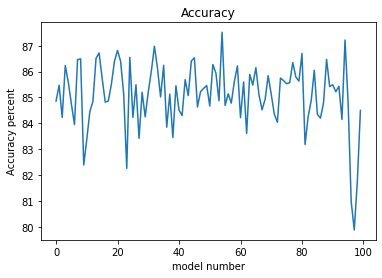

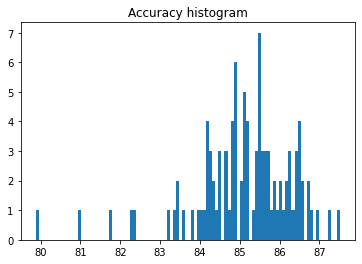

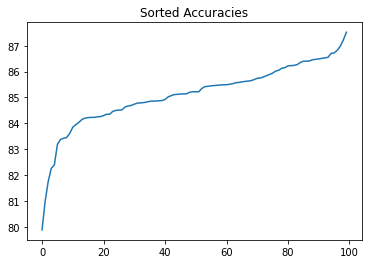

0th percentile : 	 79.88
25th percentile :	 84.50999999999999
Median :		 85.22000000000001
75th percentile :	 85.94
100th percentile :	 87.52


In [43]:
#x = np.arange(1,11) 
#y = 2 * x + 5 
plt.title("Accuracy") 
plt.xlabel("model number") 
plt.ylabel("Accuracy percent") 
plt.plot(accuracies) 
plt.show()
plt.title("Accuracy histogram") 
plt.hist(accuracies, bins = 100) 
plt.show()
sorted_accuracies = sorted(accuracies)

plt.title("Sorted Accuracies") 
plt.plot(sorted_accuracies) 
plt.show()
percentage = int(len(sorted_accuracies)/100)
print(f"0th percentile : \t {sorted_accuracies[0]}")
print(f"25th percentile :\t {sorted_accuracies[25 * percentage]}")
print(f"Median :\t\t {sorted_accuracies[50* percentage]}")
print(f"75th percentile :\t {sorted_accuracies[75 * percentage]}")
print(f"100th percentile :\t {sorted_accuracies[-1]}")

In [44]:
print(sum(vote_hist))
print(trainset.class_to_idx)

[102677. 115508.  98932.  99896. 101165.  85963.  96158. 101063.  95924.
 102714.]
{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


In [45]:
teacher_preds.shape

(10000, 100)

In [46]:
import numpy as np
from scipy import stats
stats.mode(teacher_preds[0])

ModeResult(mode=array([7.]), count=array([100]))

In [47]:
relevant_meta = {k:v for k,v in meta.items() if k[-len("_of_100"):] == "_of_100"}
sp = list(relevant_meta.items())[0][1]["save_path"]
print(sp)
model = load_model(path = sp , base_model = Model())
for batch_idx, (data, targets) in enumerate(testloader):
    #confs, preds = prediction_by_imgs(model, data)
    break      

confs, preds = prediction_by_imgs(model, data)
print(preds)
print(targets)

/content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/model_0_of_100.pth
tensor([7, 2, 1, 0, 4, 1, 4, 9, 2, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 5, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 2, 0, 4, 1, 9, 7, 7, 8, 9, 3], device='cuda:0')
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')


In [48]:

sp =relevant_meta["model_0_of_100"]["save_path"]
print(sp)
model = load_model(path = sp, base_model = Model())
for batch_idx, (data, targets) in enumerate(testloader):
    #confs, preds = prediction_by_imgs(model, data)
    break      

confs, preds = prediction_by_imgs(model, data)
print(preds)
print(targets)

/content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_6/model_0_of_100.pth
tensor([7, 2, 1, 0, 4, 1, 4, 9, 2, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 5, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 2, 0, 4, 1, 9, 7, 7, 8, 9, 3], device='cuda:0')
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')


In [ ]:
vote_hist = np.copy(vote_hist_orig)

In [ ]:
type(vote_hist)

In [ ]:
def compare(ind):
  print(f"Prediction: {vote_hist[ind]} : \t\t\tP: {np.argmax(vote_hist[ind])}")
  print(f"real :\t\t\t\t\t\t\t\tR:  {ordered_test_targets[ind]}")
  
for i in range(5):
  compare(i)


In [ ]:
def laplaceMechanism(x, epsilon):
    # sensitivity = 1
    return x + np.random.laplace(0, scale = 1.0/epsilon, size = x.shape)
    
def laplacify_votes(vote_hist, eps = 3. ):
  # https://becominghuman.ai/differential-privacy-noise-adding-mechanisms-ede242dcbb2e
  return laplaceMechanism(vote_hist, epsilon = eps)

def get_labels(vote_hist):
  return [int(np.argmax(vote)) for vote in vote_hist]


def get_new_labels(vote_hist, epsilon = 3.):
  """ Give a histogram of votes, and noise to it, and get the maximum voted for label"""
  return np.array(get_labels(laplacify_votes(vote_hist, eps = epsilon)))

def get_student_dataset_and_dataloader( epsilon=3.0):
    student_dataset = datasets.MNIST(
      "~/.pytorch/MNIST_data/", train=False, download=True, transform=transform)

    vote_hist = vote_hist_orig.copy()
    # put this back later
    student_dataset.targets = get_new_labels(vote_hist)
    student_dataloader = load(student_dataset)
    # send this to the device
    student_dataloader = DeviceDataLoader(student_dataloader, device)
    return student_dataset, student_dataloader

In [ ]:
m = 4
c = 0
for i, noisy_i in zip(vote_hist, laplacify_votes(vote_hist, eps =1000)):
  print(f"diff between vote and laplacified votes:  {i.astype(int) - noisy_i.astype(int)}")
  print(f"diff between vote and laplacified votes:  {sum(i.astype(int) - noisy_i.astype(int))}")
  print(np.argmax(i))
  #print(noisy_i.astype(int))
  print(np.argmax( noisy_i))
  print("---")
  c+=1
  if c>m:
    break


In [ ]:
#vote_hist_orig[:5]
vote_hist[:4]

In [ ]:
meta.keys()

In [ ]:
trainset.targets[:5]

In [ ]:
student_dataset, student_dataloader = get_student_dataset_and_dataloader( epsilon=3.)

In [ ]:
# how often does the new targets differ from the old targets:
diffs = 0
for i in range(len(testset.targets)):
  if student_dataset.targets[i] != ordered_test_targets[i]: #testset.targets[i]:
    diffs+=1
print(f"{diffs} /{len(testset)}. alignment : {100* (1-(diffs/len(testset)))}%")

## Train Student

In [ ]:
student_dataset.targets

In [ ]:
model = to_device(Model(), device)

EPOCHS = 40
epsilon = 1.0

student_dataset, student_dataloader = get_student_dataset_and_dataloader( epsilon=epsilon)

base_save = os.path.join(f"{ASSETS_BASE_PATH}",f"num_teachers_{num_teachers}__student_{epsilon}")
# make the directory to which we will save stuff
os.makedirs(os.path.dirname(base_save), exist_ok =True) 
tensorboard_path = base_save 
save_path = base_save + ".pth"
print(f"tensorboard path is {tensorboard_path}")
print(f"save_path is {save_path}")
model_name = f"student"
# 

meta = open_yaml(meta_yaml)
if not meta:
  print(f"no data in {meta_yaml}")
  meta = {}
  
student_info = do_it_all(model = model, model_name = model_name,
                                save_path = save_path, tensorboard_path= tensorboard_path, 
                                trainloader_ = student_dataloader, val_loader_ = testloader,
                                num_classes = num_classes, device = device, epochs = EPOCHS)
meta[f"student_eps{epsilon}"] = student_info
if student_info:
  write_yaml(meta_yaml, meta)

In [ ]:
list(meta.items())[0]

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/academics/columbia/neural_networks/project/data/round_4

In [ ]:
%%capture
!python3 -m pip install syft==0.2.9


In [ ]:
import syft as sy
from syft.frameworks.torch.dp import pate

In [ ]:
teacher_preds

In [ ]:

?pate.perform_analysis

In [ ]:
%%time 
%%capture

eps_test = [0.3, 1.0, 2.0, 4., 10., 40.]
eps_d = {}
for eps in eps_test:
    print(f"eps : {eps}")
    vote_hist = np.copy(vote_hist_orig)
    data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=teacher_preds.T.astype(int), # note might need to transpose this
                                                      indices= get_new_labels(vote_hist, epsilon = eps), # student_dataset.targets, 
                                                      noise_eps=epsilon, 
                                                      delta=1e-5);
    print("Data Independent Epsilon:", data_ind_eps)
    print("Data Dependent Epsilon:", data_dep_eps)
    eps_d[eps] = {"data_dep_eps": data_dep_eps, "data_dep_eps, data_ind_eps": data_ind_eps}

In [ ]:
for k,v in eps_d.items():
  print(f"{k}: {v}")

In [ ]:
# https://blog.openmined.org/build-pate-differential-privacy-in-pytorch/

In [ ]:
model.device

In [ ]:
device

In [ ]:
student_dataloader.device

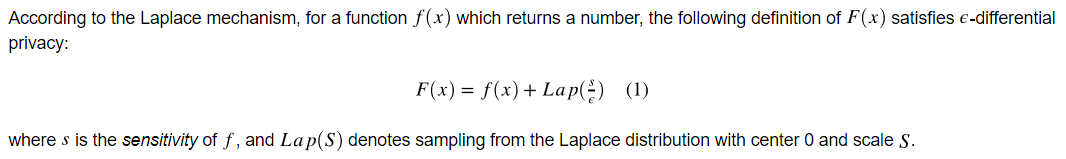

In [ ]:
np.random.laplace(0, scale = 1/10.)

In [ ]:
data[0].shape

In [ ]:
len(data)

In [ ]:
conf, pred = prediction_by_imgs(model, data)
pred